In [38]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option("display.max_row", 100)
import numpy as np

import math
import random

In [39]:
### NOTE:  ChannelShape.py is in ~kelsey/jupyter directory
### Right now, this also imports the CDMSlite channel shapes; that will change!
from ChannelShape import *

In [62]:
# Uniform disk of specified radius
def diskWt(pos, rDisk):
    r,phi = ChannelShape.cart2pol(pos)
    return 1. if r<=rDisk else 0.

# Circular Gaussian distribution, integrated over disk radius
gaussRMS = 6
gaussDisk = 20
def gaussWt(pos, rDisk):
    r,phi = ChannelShape.cart2pol(pos)
    Rsq = gaussRMS**2
    return 0.5*gaussDisk**2/Rsq * exp(-0.5*r**2/Rsq)

In [63]:
def getOverlap(hitpos, rFast, chan, **kwargs):
    """Return integral of weighted "fast circle" within channel area
       hitpos: two-vector (x,y) of hit in detector
       rFast: radius of fast circle to be integrated
       chan: instance of ChannelShape
       wtfunc: (optional) function to return weight at position
               weight should be normalized to average 1. over "fast circle"
    """
    
    wtfunc = kwargs['wtfunc'] if 'wtfunc' in kwargs else diskWt

    chanSum = 0.
    Nthrow = 100000
    for i in range(Nthrow):
        rThrow = rFast * math.sqrt(random.random())
        phiThrow = random.uniform(0.,2.*math.pi)
        posThrow = ChannelShape.pol2cart((rThrow,phiThrow))
        
        posFull = tuple(map(sum, zip(posThrow,hitpos)))   # ??Easier way to add coordiates??
        if chan.contains(posFull): chanSum += wtfunc(posThrow, rFast)
            
    chanSum /= float(Nthrow)
    
    return chanSum

In [64]:
def getAllOverlaps(hitpos, rFast, chanset, **kwargs):
    """Return dictionary of integrals of weighted "fast circle" within
       multiple channel areas at once.
       hitpos: two-vector (x,y) of hit in detector
       rFast: radius of fast circle to be integrated
       chanset: dictionary of ChannelShape objects by name
       wtfunc: (optional) function to return weight at position
               weight should be normalized to average 1. over "fast circle"
    """
    
    wtfunc = kwargs['wtfunc'] if 'wtfunc' in kwargs else diskWt

    chanSum = {ch: 0. for ch in chanset}           # Initialize set of all overlaps
    Nthrow = 100000
    for i in range(Nthrow):
        rThrow = rFast * math.sqrt(random.random())
        phiThrow = random.uniform(0.,2.*math.pi)
        posThrow = pol2cart((rThrow,phiThrow))      # Random point chosen within fast circle
        
        posFull = tuple(map(sum, zip(posThrow,hitpos)))   # ??Easier way to add coordiates??
        for ch in chanset:
            if chanset[ch].contains(posFull): chanSum[ch] += wtfunc(posThrow, rFast)
    
    for ch in chanset:
        chanSum[ch] /= float(Nthrow)
    
    return chanSum

In [47]:
# Compute outer/inner ratio for specified channel fractions
def outVsIn(frac):
    """Compute outer/inner ratio: frac must be dictionary indexed on channel names."""
    return frac['PA']/(frac['PB']+frac['PC']+frac['PD'])

In [65]:
# Generate points from 0 out to detector radius (38.1 mm)
# Sum up three inner channels, and make a plot of A/BCD vs. radius
# WARNING: getAllOverlaps() throws 100k points for each integration,
#          so this loop can take noticeable time.

def ratioA_BCD(fastTot=0.07):
    global gaussRMS 
    global gaussDisk
    gaussDisk = 4.*gaussRMS
    
    fastRatio = np.array([])
    fullRatio = np.array([])

    radii = np.arange(0., 38.1, 0.5)
    for r in radii:
        fast = getAllOverlaps((r,0.), gaussDisk, chanset, wtfunc=gaussWt)
        # Assign everything outside PA to fast['PA']
        ### fast['PA'] = fastTot - (fast['PB']+fast['PC']+fast['PD'])
        slowTot = 1 - fastTot*sum(fast.values())
        slow = {k: slowTot/len(fast) for k in fast.keys()}
        frac = {k: (fastTot*fast[k]+slow[k]) for k in fast.keys()}
        fastRatio = np.append(fastRatio, outVsIn(fast))
        fullRatio = np.append(fullRatio, outVsIn(frac))

    plt.scatter(radii,fullRatio)

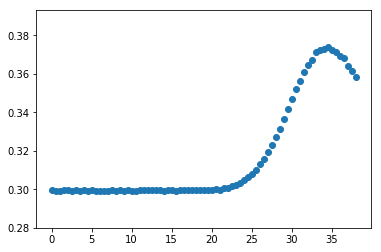

In [71]:
gaussRMS = 4
ratioA_BCD(0.06)

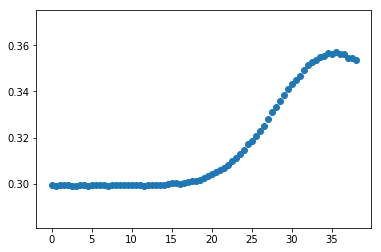

In [72]:
gaussRMS = 6
ratioA_BCD(0.06)

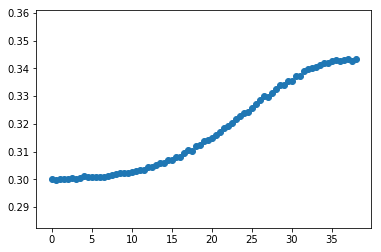

In [73]:
gaussRMS = 10
ratioA_BCD(0.06)